In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from kornia.morphology import gradient
from torchvision.utils import make_grid
from vitRet.data.fundus import EyePACSDataModule
from vitRet.models.stochastic_attention.stochastic_vit import StochasticVisionTransformer


In [17]:
data_dir = '/home/tmp/clpla/data/eyepacs/'
img_size = (1024, 1024)
scales = 1
device = 1
datamodule = EyePACSDataModule(data_dir, img_size=img_size, batch_size=2, num_workers=2, superpixels_scales=scales, 
                               superpixels_filter_black=True,
                               superpixels_max_nb=8192,
                               superpixels_min_nb=4096)
datamodule.setup('test')

2893


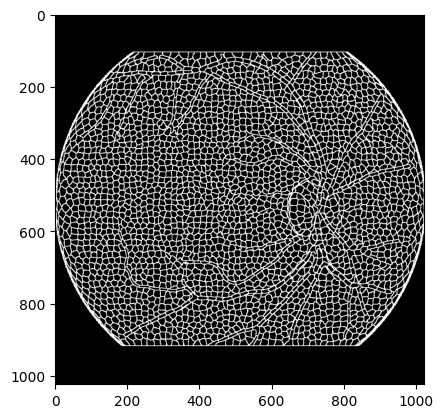

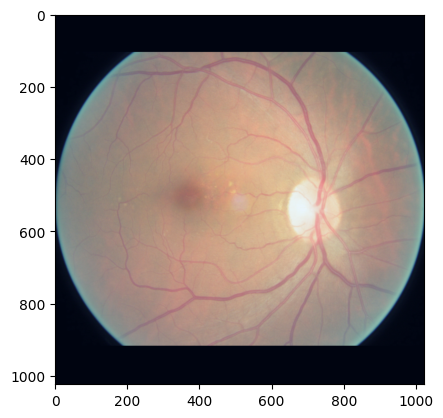

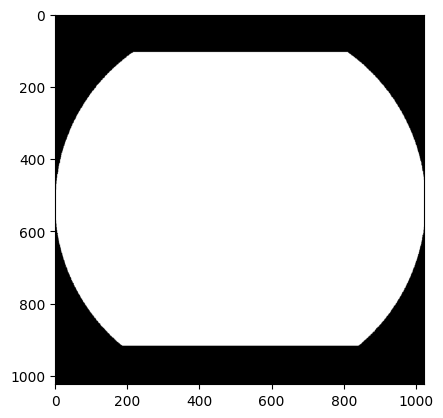

In [18]:
def plot_segments(segments, gradients=True):
    print(len(torch.unique(segments)))
    if segments.ndim==3:
        segments.unsqueeze_(0)
    if gradients:
        kernel = torch.ones(3,3)
        segments = gradient(segments, kernel=kernel)>0
    if segments.ndim==4:
        segments.squeeze_(0)
    n_segments = segments.shape[0]
    fig, axs = plt.subplots(1, n_segments)
    if n_segments==1:
        axs = [axs]
    for ax, seg in zip(axs, segments):
        ax.imshow(seg)
    plt.show()
dataset = datamodule.test
index = 10
batch = dataset[index]
plot_segments(batch['segments'])
img = batch['image'].permute(1,2,0).numpy()
img = (img-img.min())/(img.max()-img.min())
plt.imshow(img)
plt.show()
plt.imshow(batch['mask'])
plt.show()

In [19]:
import torch

ckpt_path = '../checkpoints/dry-river-285/epoch=16-step=22049.ckpt'
ckpt_path = '../checkpoints/dry-river-285/last.ckpt'
model = StochasticVisionTransformer(num_classes=1, 
                                    scales=scales,
                                    img_size=img_size, 
                                    kernel_size=16,
                                    qkv_bias=True, drop_path=0.2,
                                    first_embedding_dim=32,
                                    global_pool=False,
                                    projection_stride=1).cuda(device)

state_dict = torch.load(ckpt_path, map_location='cpu')['state_dict']
for k in list(state_dict.keys()):
    state_dict[k.replace('model.', '')] = state_dict.pop(k)
state_dict['tokenizer.cls_token'].squeeze_(1)


state_dict['projector.pos_embed'] = F.interpolate(state_dict['projector.pos_embed'], 
                                                  size=model.projector.pos_embed.shape[-2:], 
                                                  mode='bilinear')
model.load_state_dict(state_dict=state_dict, strict=True)

<All keys matched successfully>

In [20]:
dataloader = datamodule.test_dataloader()
dataloader.dataset.subset(np.where(dataloader.dataset.gts['label']==3))
iterdata = iter(dataloader)
batch = next(iterdata)

/home/clement/miniconda3/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


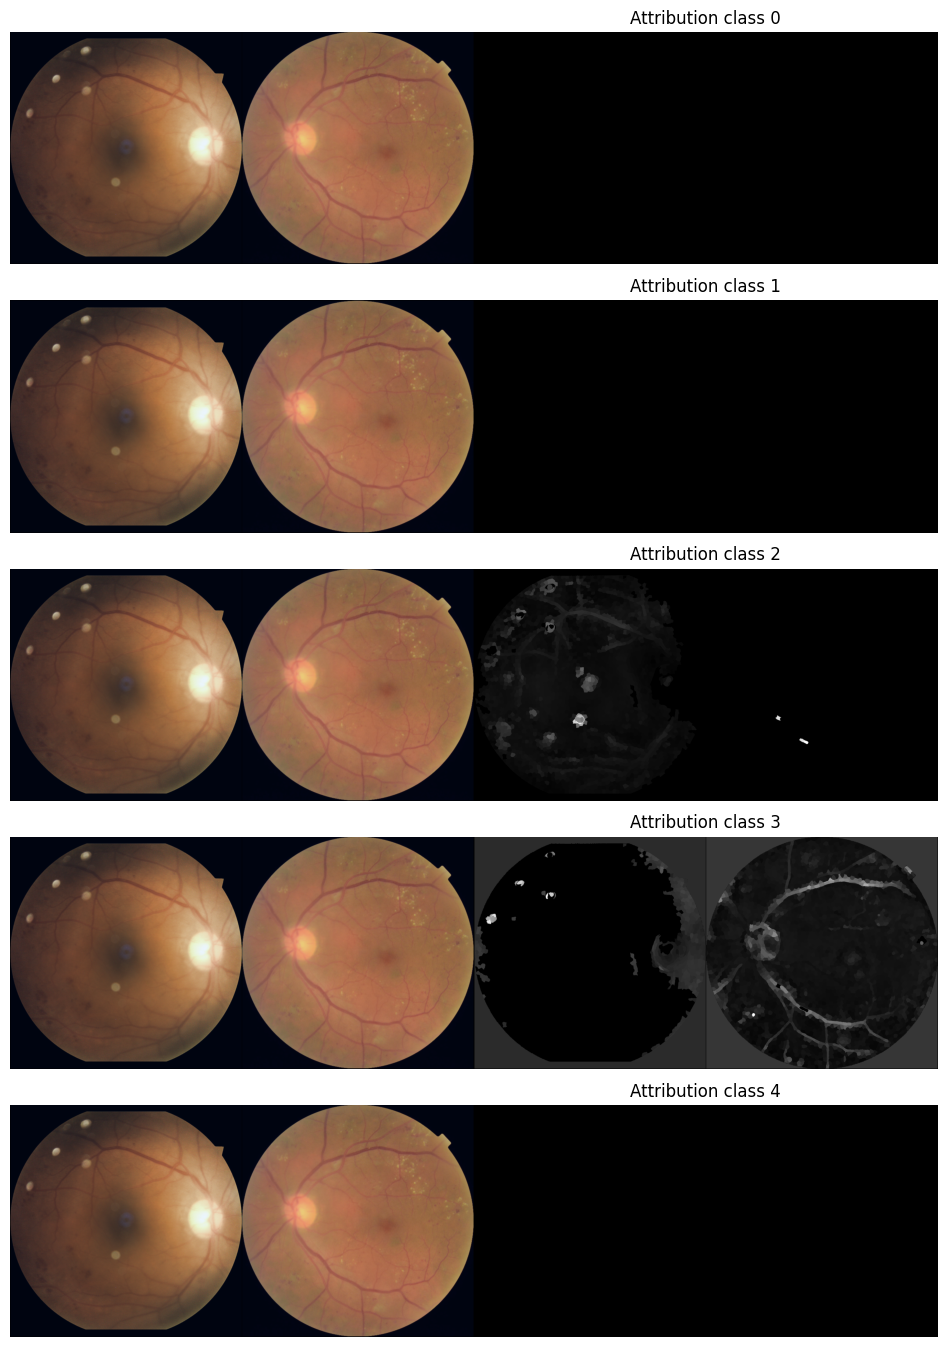

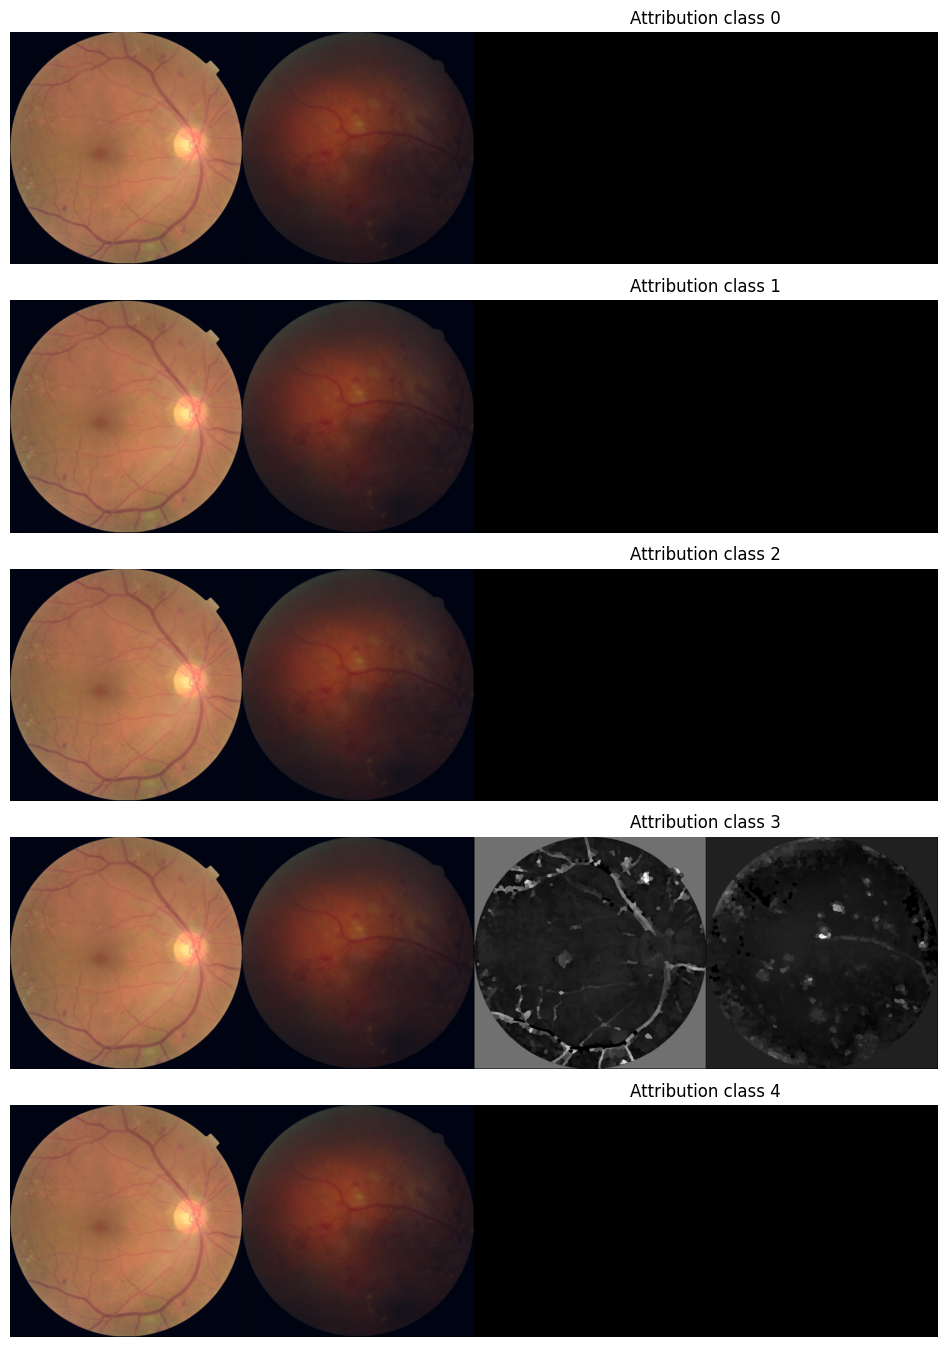

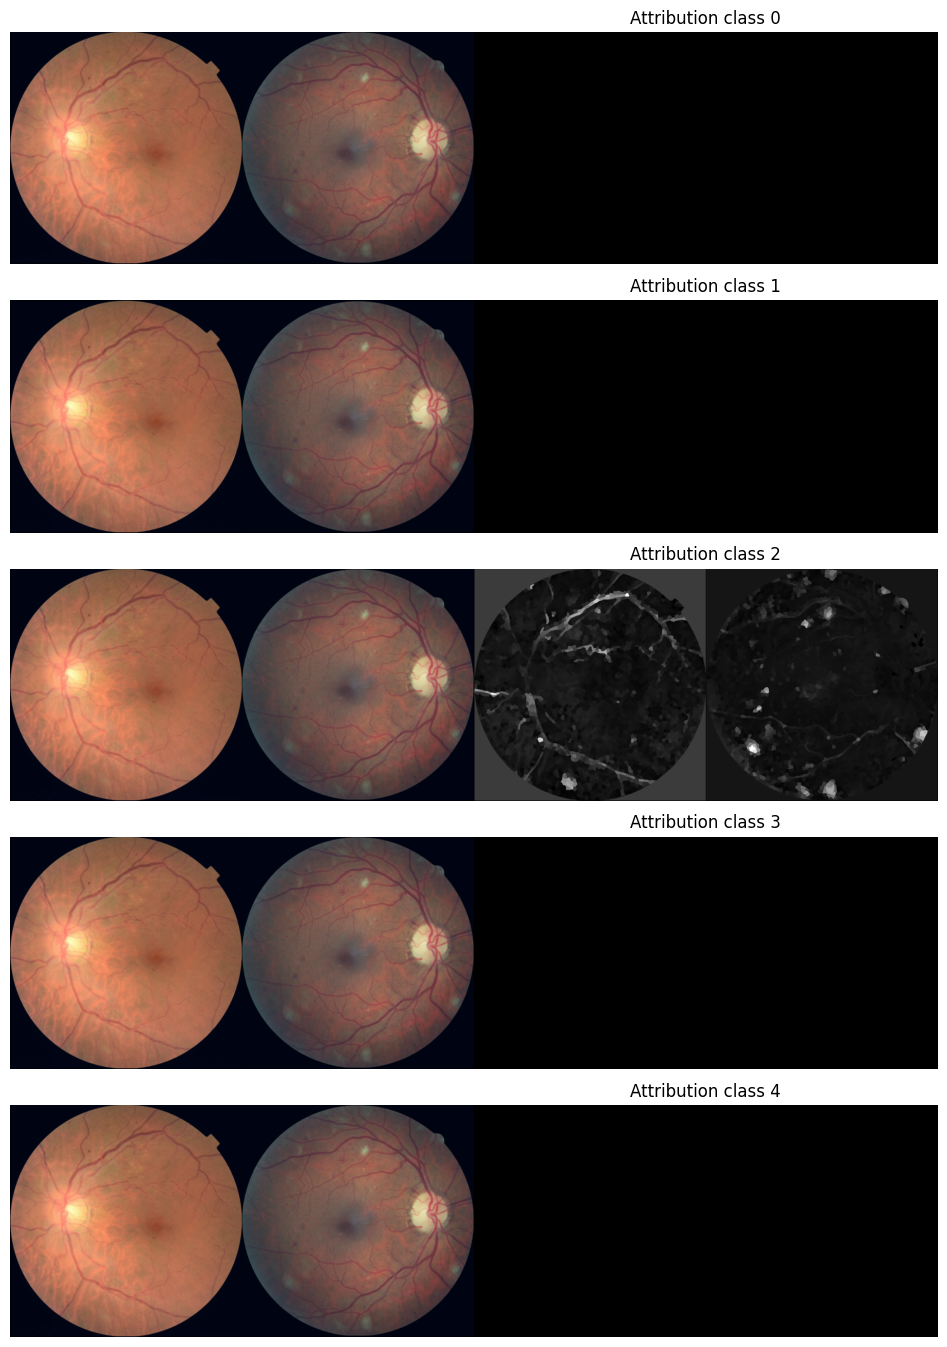

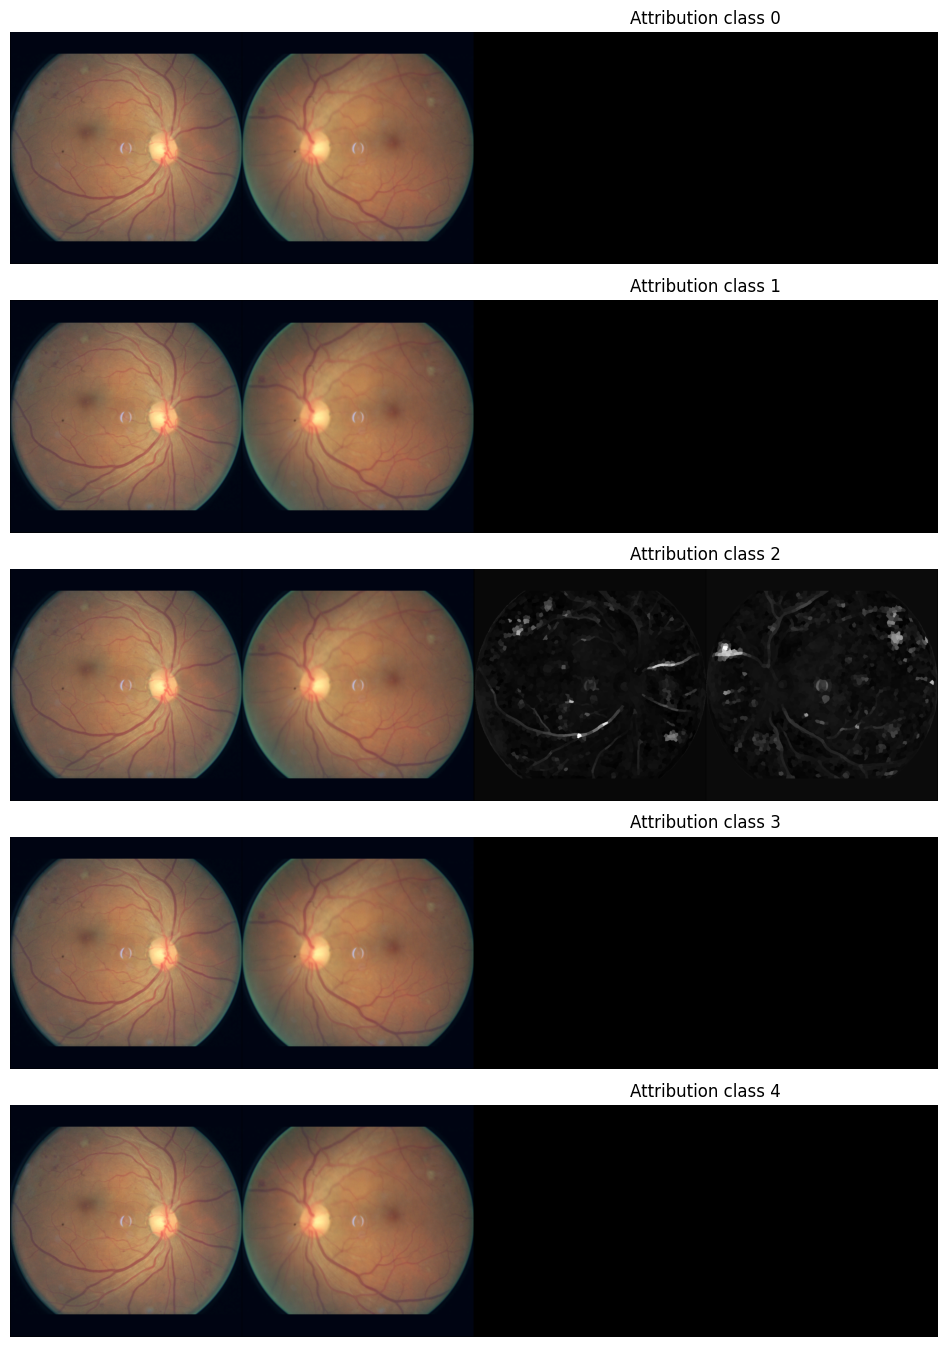

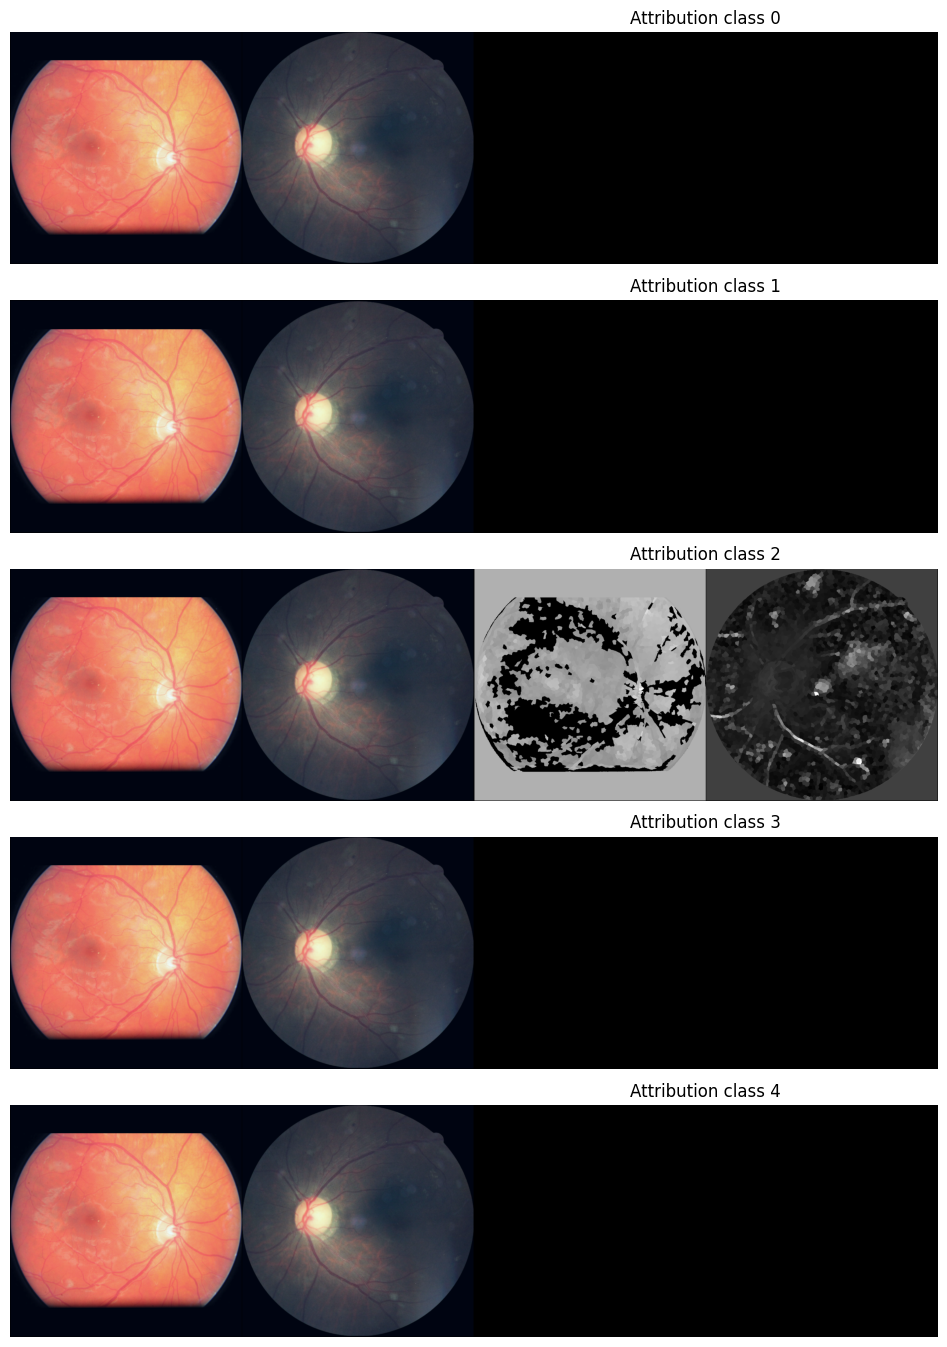

In [21]:
model.eval()
for i in range(5):
    batch = next(iterdata)
    fig, axs = plt.subplots(5, 2)
    fig.set_size_inches(10, 14)
    fig.tight_layout()
    for attr in range(5):
        model.attr_cls = attr
        with torch.no_grad():
            pred, attn = model(batch['image'].cuda(device), batch['segments'].cuda(device), True)

        images_grid = make_grid(batch['image'], normalize=True, nrow=2).cpu()
        attn_grid = make_grid(attn.unsqueeze(1), normalize=True, nrow=2).cpu()        
        axs[attr, 0].imshow(images_grid.permute(1, 2, 0))
        axs[attr, 1].imshow(attn_grid.permute(1, 2, 0))
        axs[attr, 0].axis('off')
        axs[attr, 1].axis('off')
        axs[attr, 1].set_title(f'Attribution class {attr}')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
